<a href="https://colab.research.google.com/github/vasilijeIT23/PPPO_Age_Gender_Emotion_Detection/blob/main/pppo_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AGE DETECTION MODEL NOTEBOOK FOR AGE_GENDER_EMOTION PROJECT


In [ ]:
# Import dependencies
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
import zipfile
import csv
from sklearn.metrics import confusion_matrix
import itertools

All methods needed for data preprocessing and model training. Methods are explained below, since every method is commented out.

In [ ]:
def unzip_file(zip_file_path, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the destination folder
        zip_ref.extractall(destination_folder)

def create_metadata_csv(root_folder, csv_output_path):
    with open(csv_output_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['image_name', 'emotion'])

        for foldername, _, filenames in os.walk(root_folder):
            # Extract emotion label from the folder name
            emotion = os.path.basename(foldername)

            for filename in filenames:
                path_end = os.path.join(foldername, filename)
                # Construct the relative path to the image
                relative_path = os.path.join(root_folder, path_end)

                # Write the image name and emotion label to the CSV file
                csv_writer.writerow([relative_path, emotion])

def split_train_test(metadata, test_size=0.2, random_state=42):
    # Split the metadata DataFrame into train and test sets
    train_metadata, test_metadata = train_test_split(metadata, test_size=test_size, random_state=random_state)

    return train_metadata, test_metadata

def class_labels_reassign(emotion):
    if emotion == 'happy':
        return 0
    elif emotion == 'anger':
        return 1
    elif emotion == 'contempt':
        return 2
    elif emotion == 'disgust':
        return 3
    elif emotion == 'fear':
        return 4
    elif emotion == 'sadness':
        return 5
    else:
        return 6

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

def count_files_per_folder(root_folder):
    folder_file_count = []

    for foldername, subfolders, filenames in os.walk(root_folder):
        # Exclude the root folder itself
        if foldername != "dont_include":
            file_count = len(filenames)
            folder_file_count.append((foldername, file_count))

    return folder_file_count

Original data is contained on drive in zipped folder on drive, and below is unzipping data method execution.

In [ ]:
zipped_file_path = '/content/drive/MyDrive/emotion_dataset.zip'
unzip_path = '/content/drive/MyDrive/PPPO/emotion_detection/initial_data'

unzip_file(zipped_file_path, unzip_path)

Checking data distribution among different emotions.

In [ ]:
root_folder = '/content/drive/MyDrive/PPPO/emotion_detection/initial_data'

folder_file_count = count_files_per_folder(root_folder)

for folder, file_count in folder_file_count:
    print(f"Folder: {folder}, Number of Files: {file_count}")

folders = [folder[len(folder)-10: len(folder)] for folder, _ in folder_file_count]
file_counts = [file_count for _, file_count in folder_file_count]

Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data, Number of Files: 0
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/anger, Number of Files: 135
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/contempt, Number of Files: 54
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/disgust, Number of Files: 177
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/fear, Number of Files: 75
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/happy, Number of Files: 207
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/sadness, Number of Files: 84
Folder: /content/drive/MyDrive/PPPO/emotion_detection/initial_data/surprise, Number of Files: 249


Visualising data using bar and pie chart.

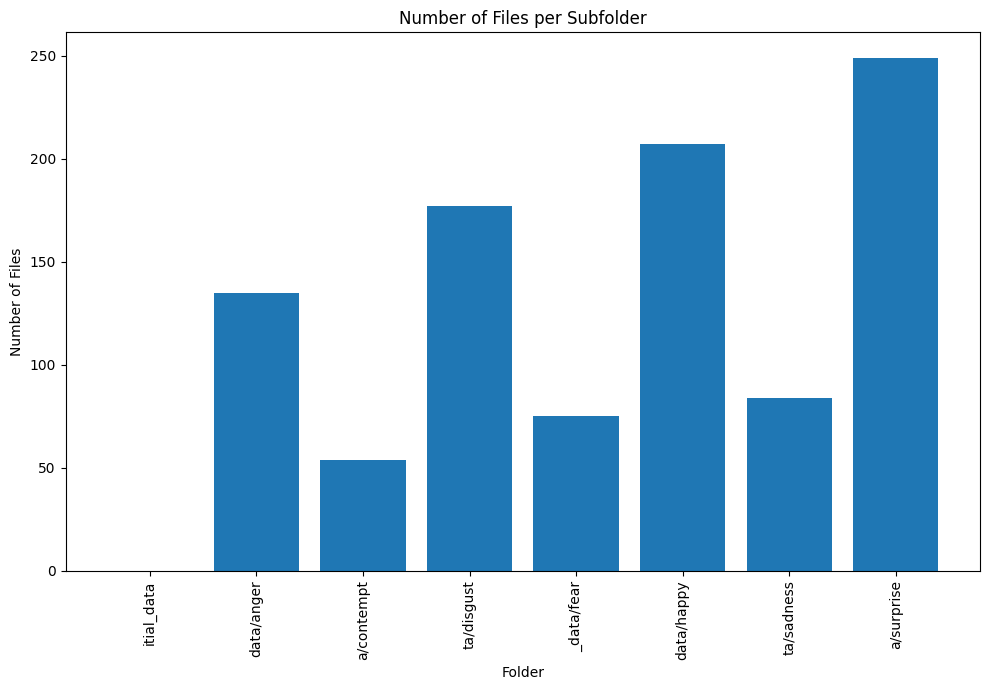

In [ ]:
# Plotting
plt.figure(figsize=(10, 7))
plt.bar(folders, file_counts)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

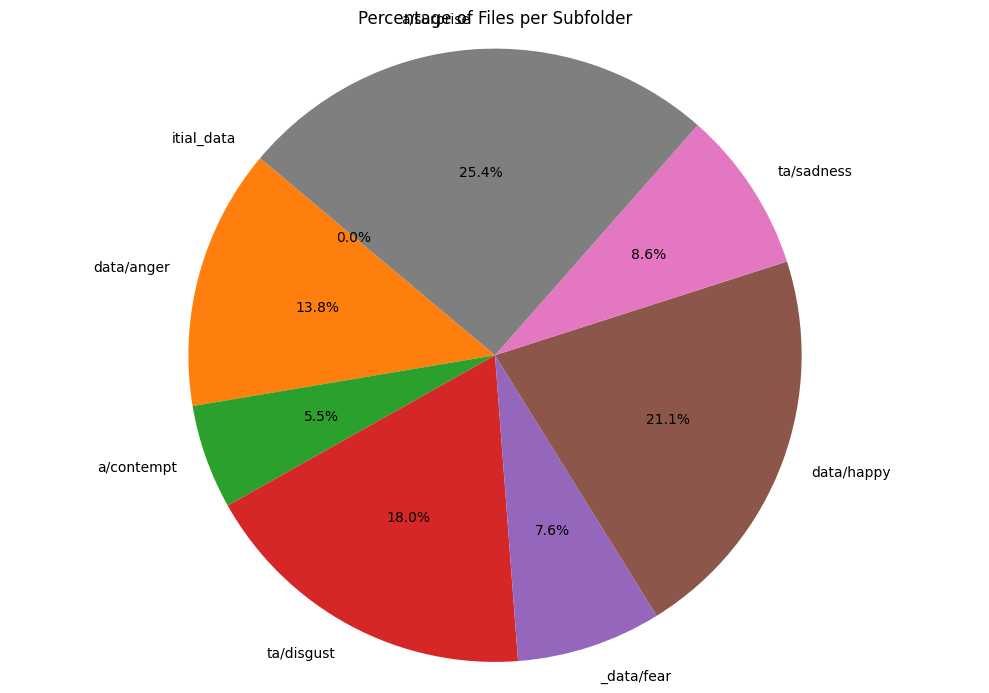

In [ ]:
# Plotting Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(file_counts, labels=folders, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Files per Subfolder')
plt.tight_layout()

plt.show()

Creating metadata csv file with all necessary labels.

In [ ]:
root_folder = '/content/drive/MyDrive/PPPO/emotion_detection/initial_data'
csv_output_path = '/content/drive/MyDrive/PPPO/emotion_detection/metadata.csv'

create_metadata_csv(root_folder, csv_output_path)

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/PPPO/emotion_detection/metadata.csv').sample(frac=1, random_state=42)
print(metadata)

                                            image_name   emotion
789  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise
497  /content/drive/MyDrive/PPPO/emotion_detection/...     happy
139  /content/drive/MyDrive/PPPO/emotion_detection/...  contempt
570  /content/drive/MyDrive/PPPO/emotion_detection/...     happy
66   /content/drive/MyDrive/PPPO/emotion_detection/...     anger
..                                                 ...       ...
106  /content/drive/MyDrive/PPPO/emotion_detection/...     anger
270  /content/drive/MyDrive/PPPO/emotion_detection/...   disgust
860  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise
435  /content/drive/MyDrive/PPPO/emotion_detection/...      fear
102  /content/drive/MyDrive/PPPO/emotion_detection/...     anger

[981 rows x 2 columns]


Splitting into train and test sets with 0.8 - 0.2 ratio

In [ ]:
train_set, test_set = split_train_test(metadata)

print("Train: ", train_set)
print("Test: ", test_set)

Train:                                              image_name   emotion
71   /content/drive/MyDrive/PPPO/emotion_detection/...     anger
225  /content/drive/MyDrive/PPPO/emotion_detection/...   disgust
566  /content/drive/MyDrive/PPPO/emotion_detection/...     happy
693  /content/drive/MyDrive/PPPO/emotion_detection/...   sadness
30   /content/drive/MyDrive/PPPO/emotion_detection/...     anger
..                                                 ...       ...
976  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise
514  /content/drive/MyDrive/PPPO/emotion_detection/...     happy
812  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise
868  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise
692  /content/drive/MyDrive/PPPO/emotion_detection/...   sadness

[784 rows x 2 columns]
Test:                                              image_name   emotion
242  /content/drive/MyDrive/PPPO/emotion_detection/...   disgust
765  /content/drive/MyDrive/PPPO/emotion_detection/

Now we are preparing the data to be acceptable as input value for model training process.

Adding numerical value to each emotion in dataset

In [ ]:
train_set['target'] = train_set['emotion'].map(class_labels_reassign)
test_set['target'] = test_set['emotion'].map(class_labels_reassign)

In [ ]:
print(train_set)
print(test_set)

                                            image_name   emotion  target
71   /content/drive/MyDrive/PPPO/emotion_detection/...     anger       1
225  /content/drive/MyDrive/PPPO/emotion_detection/...   disgust       3
566  /content/drive/MyDrive/PPPO/emotion_detection/...     happy       0
693  /content/drive/MyDrive/PPPO/emotion_detection/...   sadness       5
30   /content/drive/MyDrive/PPPO/emotion_detection/...     anger       1
..                                                 ...       ...     ...
976  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise       6
514  /content/drive/MyDrive/PPPO/emotion_detection/...     happy       0
812  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise       6
868  /content/drive/MyDrive/PPPO/emotion_detection/...  surprise       6
692  /content/drive/MyDrive/PPPO/emotion_detection/...   sadness       5

[784 rows x 3 columns]
                                            image_name   emotion  target
242  /content/drive/MyDrive

In [ ]:
train_filenames_list = list(train_set['image_name'])
train_labels_list = list(train_set['target'])
test_filenames_list = list(test_set['image_name'])
test_labels_list = list(test_set['target'])

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
print(test_filenames_tensor)
print(test_labels_list)

tf.Tensor(
[b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/disgust/S062_005_00000029.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/surprise/S046_002_00000004.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/happy/S099_004_00000014.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/happy/S128_011_00000014.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/surprise/S117_001_00000013.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/sadness/S011_002_00000020.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/surprise/S115_001_00000008.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/contempt/S502_002_00000007.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/happy/S034_005_00000010.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_data/surprise/S060_003_00000018.png'
 b'/content/drive/MyDrive/PPPO/emotion_detection/initial_dat

In [ ]:
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.
num_classes = 7

# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
print(test_dataset)
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>


Below is shown the architecture of the model that is going to be trained. Im using CNN with 4 convolution and 4 pooling layers 4 activation and flatten, 2 dense and dropout layers in the end.

In [ ]:
# CNN Architecture
input = Input(shape = (48,48,1))
conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)
conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)
conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)
conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128,activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(7,activation="sigmoid")(drop_1)

# Model compile
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
fle_s='/content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 dropout_10 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                           

Model training.

In [ ]:
save = model.fit(train_dataset,batch_size=32,validation_data=(test_dataset),epochs=50,callbacks=[callback_list])

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 9.3591 - accuracy: 0.2258
Epoch 1: loss improved from inf to 9.35910, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
25/25 [==============================] - 13s 429ms/step - loss: 9.3591 - accuracy: 0.2258 - val_loss: 2.0505 - val_accuracy: 0.4010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.9920 - accuracy: 0.3737
Epoch 2: loss improved from 9.35910 to 1.99200, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
25/25 [==============================] - 8s 310ms/step - loss: 1.9920 - accuracy: 0.3737 - val_loss: 1.8800 - val_accuracy: 0.4569
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.8092 - accuracy: 0.4171
Epoch 3: loss improved from 1.99200 to 1.80917, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
25/25 [==============================] - 13s 529ms/step - loss: 1.8092 - accuracy: 0.4171 - val_loss: 1.7172 - val_accuracy: 0.5076
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.6131 - accuracy: 0.5026
Epoch 4: loss improved from 1.80917 to 1.61312, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
25/25 [=========================

Model fine tuning

In [ ]:
model = load_model('/content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5')
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(8)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(8)    # Same as batch_size hyperparameter in model.fit() below.

model.compile(optimizer=Adam(lr=1e-5), loss=["categorical_crossentropy"], metrics=['accuracy'])
model.fit(train_dataset,batch_size=8,validation_data=(test_dataset),epochs=50,callbacks=[callback_list])

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.9247
Epoch 1: loss did not improve from 0.25113
98/98 [==============================] - 12s 110ms/step - loss: 0.3846 - accuracy: 0.9247 - val_loss: 0.1794 - val_accuracy: 0.9848
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.9349
Epoch 2: loss did not improve from 0.25113
98/98 [==============================] - 7s 76ms/step - loss: 0.3291 - accuracy: 0.9349 - val_loss: 0.3904 - val_accuracy: 0.8985
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9349
Epoch 3: loss did not improve from 0.25113
98/98 [==============================] - 10s 106ms/step - loss: 0.3221 - accuracy: 0.9349 - val_loss: 0.2117 - val_accuracy: 0.9898
Epoch 4/50
98/98 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9503
Epoch 4: loss did not improve from 0.25113
98/98 [==============================] - 9s 91ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/50
98/98 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9719
Epoch 8: loss improved from 0.23548 to 0.22539, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
98/98 [==============================] - 11s 111ms/step - loss: 0.2254 - accuracy: 0.9719 - val_loss: 0.2615 - val_accuracy: 0.9492
Epoch 9/50
98/98 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9719
Epoch 9: loss improved from 0.22539 to 0.21601, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
98/98 [==============================] - 8s 83ms/step - loss: 0.2160 - accuracy: 0.9719 - val_loss: 0.2060 - val_accuracy: 0.9848
Epoch 10/50
98/98 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9770
Epoch 10: loss improved from 0.21601 to 0.19718, saving model to /content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5
98/98 [========================

Lineplots showing loss and accuracy of CNN model by epochs.

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

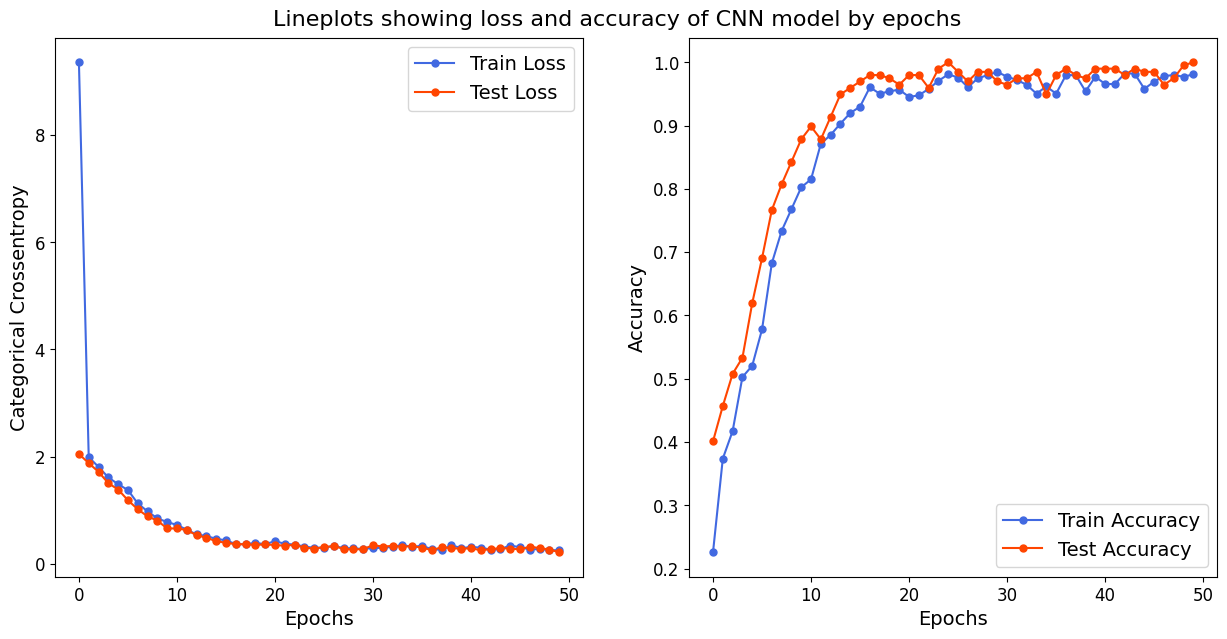

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

Confusion matrix.

25/25 [==============================] - 0s 18ms/step
Normalized confusion matrix


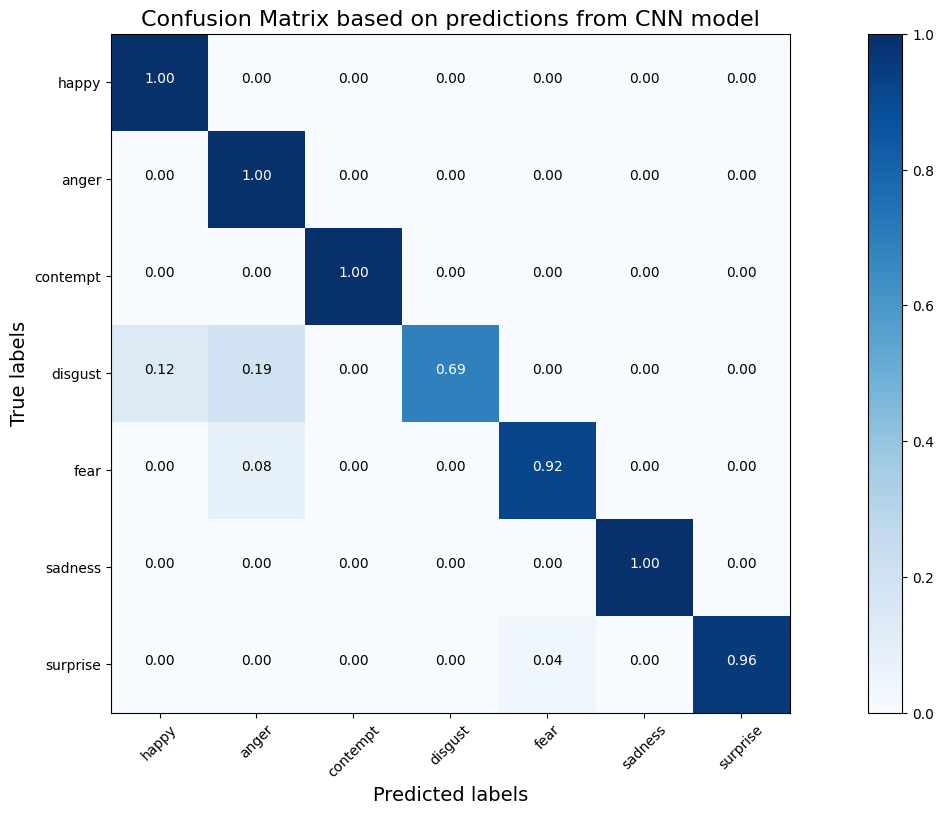

In [ ]:
# Generating predictions from the model above.
final_cnn_pred = model.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/MyDrive/output_logs/age_detection_model/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['happy', 'anger', 'contempt', 'disgust', 'fear', 'sadness', 'surprise']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()